In [27]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

### Read, transform dataset

In [28]:
# Read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [29]:
len(words)

32033

In [30]:
# Build the vocabulary of characters and mapping to/from integers
chars = sorted(list(set(''.join(words)))) # All individual words in the dataset
stoi = {s:i+1 for i,s in enumerate(chars)} # String to integer mapping
stoi['.'] = 0 # In the vocabulary doen't exist the '.' character by default, we include it at the first position
itos = {i:s for s,i in stoi.items()} # Integer to string mapping
vocab_size = len(itos)
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [31]:
# Example representing a name as a list of numbers
characters_integer = []
for ch in 'emma':
    characters_integer.append(stoi[ch])

print(torch.tensor(characters_integer))

tensor([ 5, 13, 13,  1])


### Create training, validation and test datasets

In [34]:
# Build the dataset

block_size = 3 # Context length: how many characters do we take to predict the next one

def build_dataset(words):
    X, Y = [], []
    for w in words:
        #print(w)
        # Creates a list with three elements, each of which is 0
        # This context list will be a sliding window always containing the previous three characters
        # in order to predict the next
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            # Our input data now will be a context of size three different to the context of size one we builded
            # in the previous code lab
            X.append(context)
            Y.append(ix)
            #print(''.join(itos[i] for i in context), '--->', itos[ix])
            # Update the context window to include the lastest character while discarding the oldesde one
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(f'X.shape, Y.shape: {X.shape, Y.shape}')
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words)) # 80% of the words
n2 = int(0.9*len(words)) # 90% of the words

Xtr, Ytr = build_dataset(words[:n1]) # 80% for training
Xdev, Ydev = build_dataset(words[n1:n2]) # 10% for validation/dev
Xte, Yte = build_dataset(words[n2:]) # 10% for test

X.shape, Y.shape: (torch.Size([182580, 3]), torch.Size([182580]))
X.shape, Y.shape: (torch.Size([22767, 3]), torch.Size([22767]))
X.shape, Y.shape: (torch.Size([22799, 3]), torch.Size([22799]))


In [35]:
class Linear:
    def __init__(self, in_features, out_features, bias=True):
        self.weight = torch.randn(size=(in_features, out_features), generator=g) / in_features**0.5
        self.bias = torch.zeros(out_features) if bias else None
        
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
    

class BatchNorm1d:
    def __init__(self, dimension_input, epsilos=1e-5, momentum=0.1):
        self.epsilos = epsilos
        self.momentum = momentum
        self.training = True
        # Parameters (trained with backprop)
        # Are learnable parameters initialized as tensors of ones and zeros, respectively.
        # They are used to scale and shift the normalized data.
        self.gamma = torch.ones(dimension_input)
        self.beta = torch.zeros(dimension_input)
        # Buffers (trained with a running 'momentum update')
        # Are buffers that keep track of the running mean and variance of the data across mini-batches.
        # These are used for normalization during inference when `self.training = False`
        self.running_mean = torch.zeros(dimension_input)
        self.running_var = torch.ones(dimension_input)
        
    
    def __call__(self, x):
        # Calculate the forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True) # Batch mean
            xvar = x.var(0, keepdim=True, unbiased=True) # Batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        
        # `xNormalized` is the normalized version of `x` obtained by substracting the mean and dividing
        # by the square root of the variance plus epsilon
        xNormalized = (x - xmean) / torch.sqrt(xvar + self.epsilos) # Normalize to unit variance
        # `self.out` is calculated by scaling `xNormalized` with `self.gamma` and shifting it by `self.beta`
        self.out = self.gamma * xNormalized + self.beta
        
        # Update the buffers
        if self.training:
            with torch.no_grad():
                # `(1 - self.momentum) * self.running_mean` portion calculates how much of the previous running
                # mean to retain, in this case keep "keep 90% of the old running mean"
                # `self.momentum * xmean` calculates how much of the current batch's mean to incorporate
                # into the running mean in this case "incorporate 10%"
                
                # This approach prevent the running statistics from fluctuating too much in response
                # to any single batch, especially important when the batch size is small or the
                # data is noisy.
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
        
    
    def parameters(self):
        return [self.gamma, self.beta]
        
        


class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []
    
    
n_embd = 10 # The dimensionality of the character embedding vectors
n_hidden = 100 # The number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # For reproducibility

C = torch.randn((vocab_size, n_embd), generator=g)
# MLP architecture
layers = [
    Linear(n_embd * block_size, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size), BatchNorm1d(vocab_size)
]

with torch.no_grad():
    # Adjusting last layer's weights
    # This scales down the weights of the last layer by a factor of 0.1
    # The purpose of this adjusment is to make the ouput of the last layer less confident.
    # By reducing the magnitude of the weights, the logits(the raw output scores of the model) will be closer to zero, leading
    # to a softer probability distribution after applying a softmax.
    
    # This can help in early stages of training by preventing the model from making overly confident predictions,
    # which might be significanlty wrong and lead to harsh gradient updates.
    #layers[-1].weight *= 0.1
    layers[-1].gamma *= 0.1
    # all other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            # Scales up the weights of the linear layers by a factor of 5/3.
            # This adjustment, often called "applying gain" is used to adjust to adjust the variance of the
            # layer's output across layers.
            # Scaling up the weights helps ensure that the signal(information) doesn't vanish as it pass
            # through multiple layers of the network.
            layer.weight *= 5/3

        
parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # Number of parameters in total
for p in parameters:
    p.requires_grad = True
        

47551


In [36]:
# Same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
update_to_data_ratio = []

for i in range(max_steps):
    
    # Minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    # Where Xb[i] is the context windows (Three characters) that generates Yb[i]
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
    
    # Forward pass
    emb = C[Xb] # Embed the characters into vectors
    # Re-shape the emb tensor, keeping the first dimension unchanged and combining the last ones
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    # Computes the cross-entropy loss between the redictions `x`(output of the last layer)
    # and the true labels `Yb`
    loss = F.cross_entropy(x, Yb) # Loss function
    
    # Backward pass
    for layer in layers:
        # Ensures that gradients are retained for the outputs of all layers, which is usefull
        # for gradient-based updates and debugging
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # Update
    lr = 0.1 if i < 100000 else 0.01 # Step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
        
    # Track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    
    with torch.no_grad():
        # We are comparing the update which is (lr * p.grad), taking the std of it and 
        # dividing by the parameter data.
        # Basically this measures how great are the updates to the values
        update_to_data_ratio.append([((lr * p.grad).std() / p.data.std()).log10().item() for p in parameters])
        
    if i>= 1000:
        break
    
    #break

      0/ 200000: 3.3313


layer 2 (      Tanh): mean -0.00, std 0.64, saturated: 2.56%
layer 5 (      Tanh): mean -0.01, std 0.64, saturated: 2.59%
layer 8 (      Tanh): mean -0.01, std 0.64, saturated: 2.31%
layer 11 (      Tanh): mean -0.01, std 0.64, saturated: 2.81%
layer 14 (      Tanh): mean -0.00, std 0.64, saturated: 2.34%


Text(0.5, 1.0, 'activation distribution')

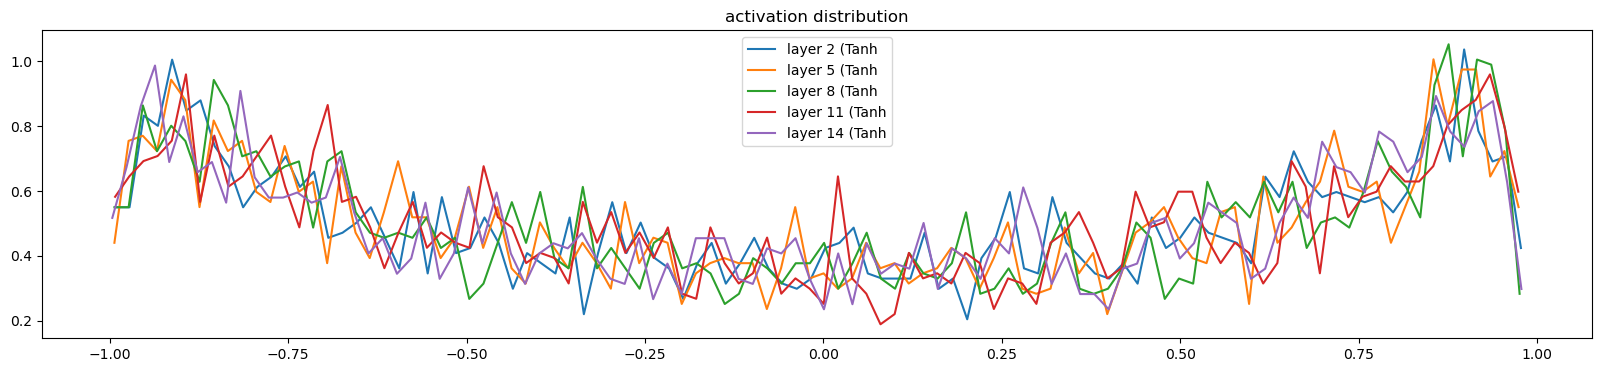

In [37]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 2 (      Tanh): mean +0.000000, std 3.860915e-03
layer 5 (      Tanh): mean +0.000000, std 3.310030e-03
layer 8 (      Tanh): mean +0.000000, std 3.105929e-03
layer 11 (      Tanh): mean -0.000000, std 2.750410e-03
layer 14 (      Tanh): mean +0.000000, std 2.485619e-03


Text(0.5, 1.0, 'gradient distribution')

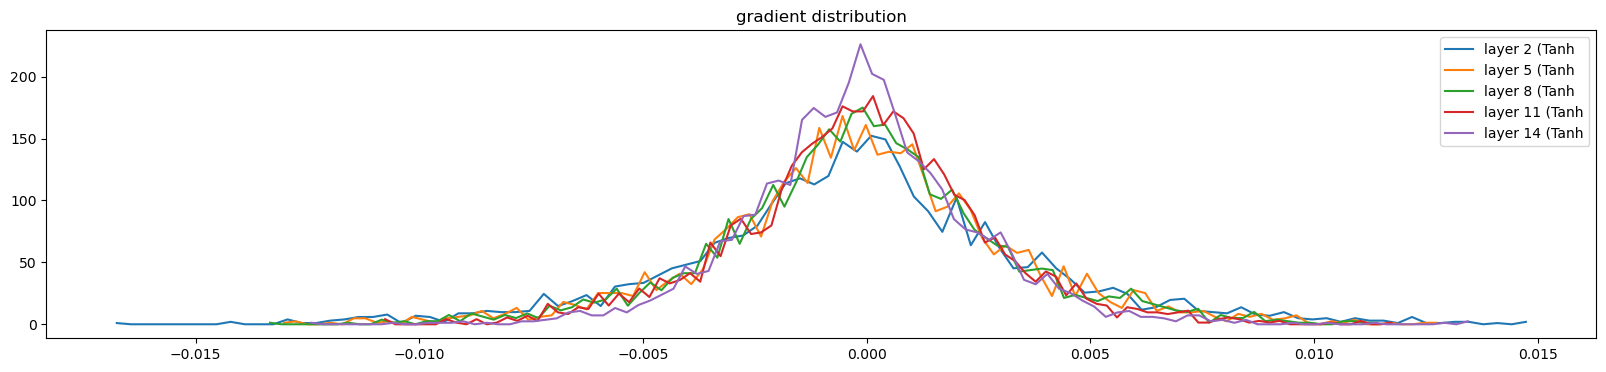

In [38]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean -0.000000 | std 9.878523e-03 | grad:data ratio 9.868569e-03
weight  (30, 100) | mean -0.000094 | std 8.747961e-03 | grad:data ratio 2.799227e-02
weight (100, 100) | mean +0.000160 | std 7.655440e-03 | grad:data ratio 4.581042e-02
weight (100, 100) | mean +0.000066 | std 6.817395e-03 | grad:data ratio 4.043709e-02
weight (100, 100) | mean +0.000010 | std 6.177767e-03 | grad:data ratio 3.681590e-02
weight (100, 100) | mean +0.000014 | std 5.331899e-03 | grad:data ratio 3.176153e-02
weight  (100, 27) | mean -0.000046 | std 9.655394e-03 | grad:data ratio 5.796682e-02


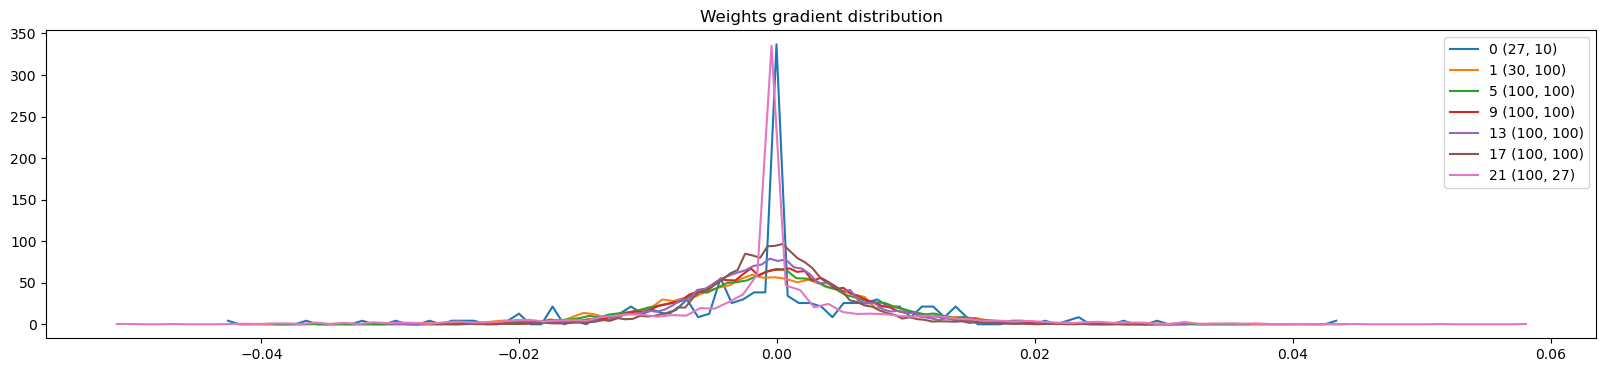

In [39]:
# Visualize parameters update histograms
# This give us a sense of what is the scale of the gradient compared to the scale of the actual values.
# This is important because we're going to end up taking a step update that is the learning rate times the gradient
# onto the data and if the gradient has too large of magnitud, if the numbers in there are too large compared to
# the number in data then we'll be in trouble
plt.figure(figsize=(20, 4)) # Width and height of the plot
legends = []
for i, p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2:
        print(f'weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'{i} {tuple(p.shape)}')
        
plt.legend(legends)
plt.title('Weights gradient distribution');

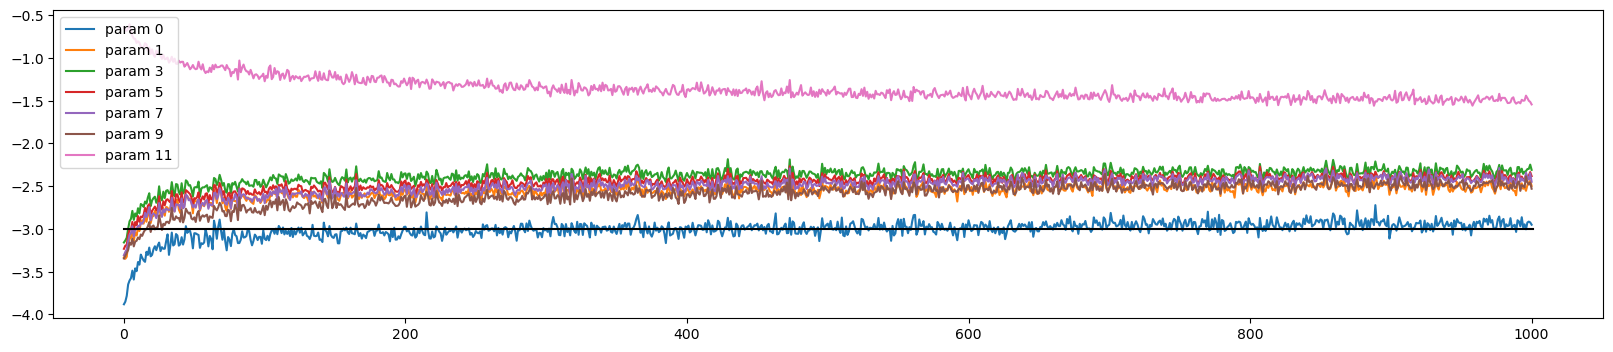

In [26]:
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([update_to_data_ratio[j][i] for j in range(len(update_to_data_ratio))])
        legends.append('param %d' % i)
        
plt.plot([0, len(update_to_data_ratio)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

In [19]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, y)
  print(split, loss.item())

# put layers into eval mode
for layer in layers:
  layer.training = False
split_loss('train')
split_loss('val')

train 1.9665724039077759
val 2.0890371799468994


In [20]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      emb = C[torch.tensor([context])] # (1,block_size,n_embd)
      x = emb.view(emb.shape[0], -1) # concatenate the vectors
      for layer in layers:
        x = layer(x)
      logits = x
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

montaymyah.
see.
madhayla.
ren.
ruthadrie.
cadelyn.
elin.
shi.
jenne.
elissa.
aarvelyn.
malaia.
noshubergihamiest.
jair.
jeniquetzalayus.
kaven.
kylene.
elsy.
majessa.
yamihil.
